In [7]:
# Regressive models - fitting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#  stationary noise
def STSeries(tau): 
    x0 = np.random.normal(0,.1,tau)
    return x0

# non-stationary process with noise
import random
def NTSeries(tau,scada):
    limit_low = 0
    limit_high = scada/2
    Iodd =  random.randint(0, 1)
    xs = np.random.normal(scada/4, tau) \
          + np.abs(np.random.normal(0, scada/2, tau) \
                   * np.sin(np.linspace(0, (3 + Iodd)*scada, tau)) ) \
          + np.sin(np.linspace(0, (5 + Iodd)*scada, tau))**2 \
          + np.sin(np.linspace(1, (7 + Iodd)*scada, tau))**2
    scaling = (limit_high - limit_low) / (max(xs) - min(xs))
    xs = xs * scaling
    eta = np.random.rand(tau)
    xs = xs + eta
    xs = xs + (limit_low - min(xs))
    return xs

# Stationary testing
########## Augmented Dickey Fuller  ADF 
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    if  dftest[1] <= 0.05:
        print(' The series  is likely stationary.')
        #return True
    else:
        print(' The series  is likely non-stationary.')
    print(dfoutput)

###### Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test 
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    if  kpsstest[1] <= 0.05:
        print(' The series  is likely stationary.')
        #return True
    else:
        print(' The series  is likely non-stationary.')
    print(kpss_output)
    
# Case 1: Both tests conclude that the series is not stationary - The series is not stationary
# Case 2: Both tests conclude that the series is stationary - The series is stationary
# Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
# Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

# evaluating regressive models using AIC
# https://analyzingalpha.com/check-time-series-stationarity-python
from statsmodels.tsa.arima_model import ARIMA
def AIC_estimate(timeseries):
    for i in range(0,2):
        for j in range(0,2):
            for k in range(0,2):
                model = ARIMA(timeseries, order=(i, j, k)).fit()
                print(i+1,j+1,k+1,model.aic)

                # AR example ar(1)

                
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

def StatPredcted(timeseries,p=1):
    # contrived dataset: timeseries
    # fit AR model
    model = AutoReg(timeseries, lags=p)
    model_fit = model.fit()
    # make prediction
    yhatAR = model_fit.predict(len(series), len(series))
    # fit MA model
    model = ARIMA(series, order=(0, 0, p))
    model_fit = model.fit()
    yhatMA = model_fit.predict(len(series), len(series))
    # fit ARMA model 
    model = ARIMA(series, order=(2, 0, p))
    model_fit = model.fit()
    yhatARMA = model_fit.predict(len(series), len(series))
    print('Prediction Error','AR=',yhatAR,'MA=', yhatMA,'ARMA=',yhatARMA)

from statsmodels.tsa.statespace.sarimax import SARIMAX
def NonStatPredcted(timeseries):
    # fit ARIMA model
    model = ARIMA(timeseries, order=(1, 1, 1))
    model_fit = model.fit()
    # make prediction
    yhatARIMA = model_fit.predict(len(timeseries), len(timeseries), typ='levels')
    # fit ARIMA model
    model = SARIMAX(timeseries, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
    model_fit = model.fit(disp=False)
    yhatSARIMAX = model_fit.predict(len(timeseries), len(timeseries))
    print('Prediction Error','ARIMA=', yhatARIMA,'SARIMAX=', yhatSARIMAX)


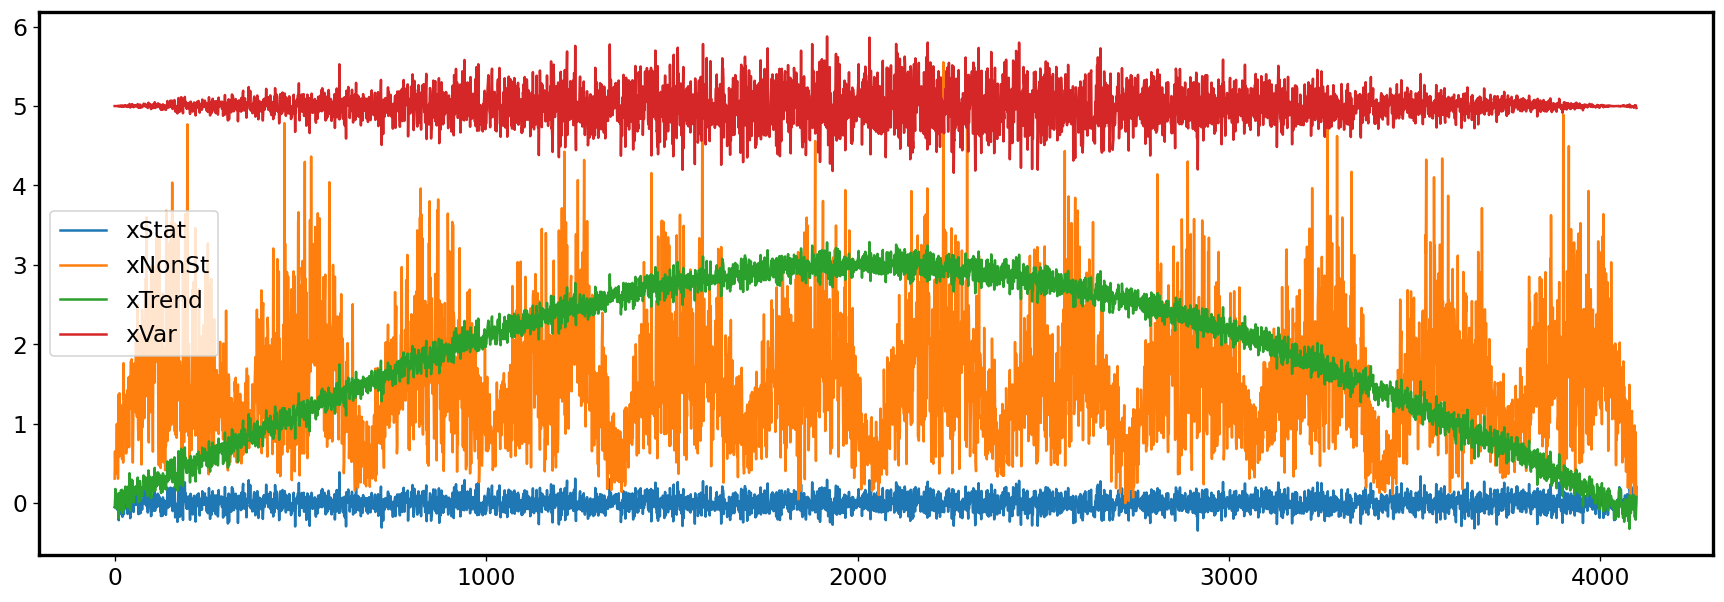

In [8]:
# main
np.random.seed(1234567)
tau = 4098
k=3
scada = k*np.pi

# tested Patterns in a time series 
xStat =  STSeries(tau)  # stationary process
xNonSt = NTSeries(tau, scada) # nonstationary (seasonal)
xc = np.linspace(0, 10, tau, endpoint=True)
xc = np.sin(k*xc/scada)
xTrend = xStat + k*xc # nonstationary (trend)
xVar = k*xc*xStat + 5

# plotting TS models
from matplotlib.pyplot import figure
figure(figsize=(18, 6), dpi=120)
plt.plot(xStat)
plt.plot(xNonSt)
plt.plot(xTrend)
plt.plot(xVar)
plt.legend(['xStat', 'xNonSt', 'xTrend', 'xVar'])

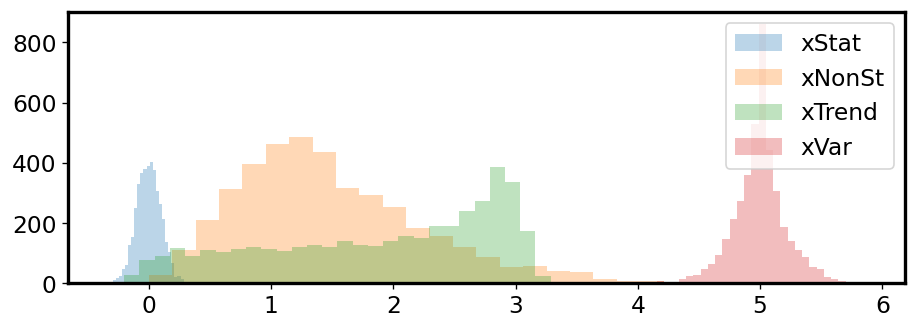

In [9]:
# tested histograms 
Nbins = int(np.ceil(1 + 3.3*np.log(tau))) 
kwargs = dict(histtype='stepfilled', alpha=0.3,  bins=Nbins)
figure(figsize=(9, 3), dpi=120)
plt.hist(xStat, **kwargs);
plt.hist(xNonSt, **kwargs);
plt.hist(xTrend, **kwargs);
plt.hist(xVar,**kwargs);
plt.legend(['xStat', 'xNonSt', 'xTrend', 'xVar'])

In [10]:
# Stationarity test under assumption that variance and covariance do not change over time
series = xNonSt
adf_test(series)
print('\n')
kpss_test(series)

Results of Dickey-Fuller Test:
 The series  is likely stationary.
Test Statistic                -6.202391e+00
p-value                        5.765125e-08
#Lags Used                     1.600000e+01
Number of Observations Used    4.081000e+03
Critical Value (1%)           -3.431953e+00
Critical Value (5%)           -2.862248e+00
Critical Value (10%)          -2.567147e+00
dtype: float64


Results of KPSS Test:
 The series  is likely non-stationary.
Test Statistic            0.022234
p-value                   0.100000
Lags Used                34.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\gcast\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


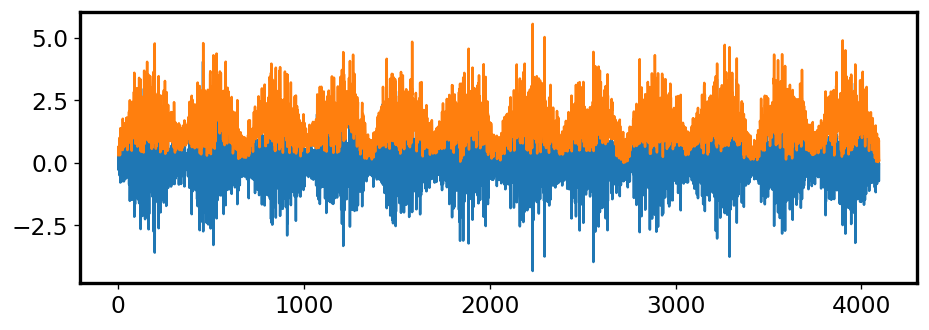

In [11]:
# detrend by diff
diff = list()
for i in range(1, len(series)):
	diff.append(series[i] -  series[i - 1])
figure(figsize=(9, 3), dpi=120)
plt.plot(np.diff(series))
plt.plot(series)
plt.show()

In [12]:
adf_test(diff)
print('\n')
kpss_test(diff)

Results of Dickey-Fuller Test:
 The series  is likely stationary.
Test Statistic                  -21.017905
p-value                           0.000000
#Lags Used                       21.000000
Number of Observations Used    4075.000000
Critical Value (1%)              -3.431956
Critical Value (5%)              -2.862250
Critical Value (10%)             -2.567148
dtype: float64


Results of KPSS Test:
 The series  is likely non-stationary.
Test Statistic             0.161372
p-value                    0.100000
Lags Used                532.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


C:\Users\gcast\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [13]:
print('Original time series')
StatPredcted(series,1)
print('Detrended time series')
StatPredcted(diff,1)

Original time series


C:\Users\gcast\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Prediction Error AR= [1.14344314] MA= [1.28210759] ARMA= [0.6912287]
Detrended time series
Prediction Error AR= [-0.0159539] MA= [1.28210759] ARMA= [0.6912287]


In [14]:
print('Original time series')
NonStatPredcted(series)
print('Detrended time series')
NonStatPredcted(diff)

Original time series
Prediction Error ARIMA= [0.59499885] SARIMAX= [0.59499885]
Detrended time series
Prediction Error ARIMA= [0.03059843] SARIMAX= [0.03059843]


<ipython-input-15-41d7d49ddb2a>:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  period = seasonal_decompose(series, model='additive', filt=None, freq=450)


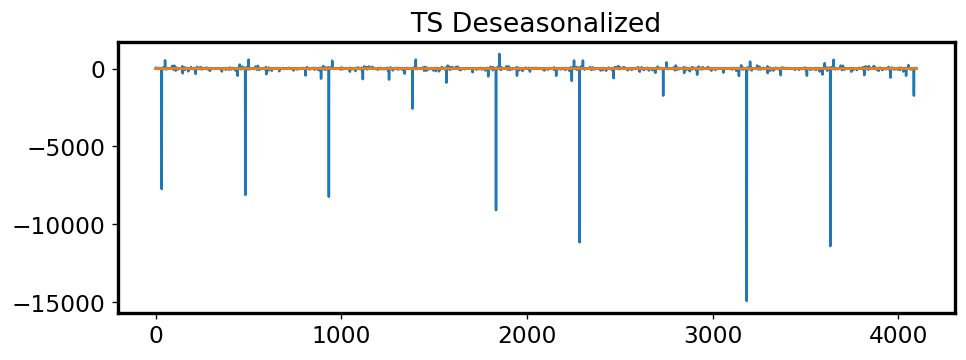

In [15]:
# deseasonalize a time series
from statsmodels.tsa.seasonal import seasonal_decompose

period = seasonal_decompose(series, model='additive', filt=None, freq=450)

# Deseasonalize
deseasonalized = series / period.seasonal

# Plot
figure(figsize=(9, 3), dpi=120)
plt.plot(deseasonalized)
plt.title('TS Deseasonalized', fontsize=16)
plt.plot(series)
plt.show()